<a href="https://colab.research.google.com/github/Abrazacs/course_work_ml/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_ML_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_IC50_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext cuml.accel

The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')
df.dropna(inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True) # убираем индекс
df.drop(['SI', 'CC50, mM'], axis=1, inplace=True) # удаляем таргеты других задач
df = df[df['IC50, mM'] <= 1550] # удаляем выбросы
df.head()

,"IC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, 0 to 1000
Columns: 211 entries, IC50, mM to fr_urea
dtypes: float64(105), int64(106)
memory usage: 1.6 MB


In [ ]:
# создаем датафрейм для хранения результатов
resulst_df = pd.DataFrame(columns=['model_name', 'params', 'train_mse', 'test_mse', 'test_r2', 'test_mae'])

def add_result(model_name, params, train_mse, test_mse, test_r2, test_mae):

  """
  Функция для добавления результатов в датафрейм
  """
  global resulst_df
  new_row = {'model_name': model_name, 'params': params, 'train_mse': -train_mse, 'test_mse': test_mse, 'test_r2': test_r2, 'test_mae': test_mae}
  resulst_df = pd.concat([resulst_df, pd.DataFrame([new_row])], ignore_index=True)

# FeatureSelector + StandardScaler

In [ ]:
feature_selector = SelectKBest(f_regression, k=15)
X = df.drop(['IC50, mM'], axis=1)
y = df['IC50, mM']
X_selected = feature_selector.fit_transform(X, y)

selected_features_mask = feature_selector.get_support()
selected_column_names = X.columns[selected_features_mask]
print(selected_column_names)

Index(['MinEStateIndex', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
       'PEOE_VSA7', 'SMR_VSA4', 'SlogP_VSA5', 'VSA_EState4', 'VSA_EState7',
       'NumAliphaticCarbocycles', 'NumSaturatedHeterocycles',
       'fr_alkyl_halide'],
      dtype='object')


In [ ]:
std_scaler = StandardScaler()
X_selected = std_scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

## KNN

In [ ]:
knn_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_grid, cv=5, scoring='neg_mean_squared_error')
knn_grid_search.fit(X_train, y_train)

model = knn_grid_search.best_estimator_
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {knn_grid_search.best_params_}')
print(f'Best score (MSE): {-knn_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('KNN + Feature selection + Standard Scaler',
           knn_grid_search.best_params_,
           knn_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best score (MSE): 74411.63541506368
MSE validation: 89656.39283485767
R2 validation: 0.23160979818587335
MAE validation: 186.03893480684405


## Random forest

In [ ]:
random_forest_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5, 0.7]
}

random_forest_grid_search = GridSearchCV(RandomForestRegressor(), random_forest_grid, cv=5, scoring='neg_mean_squared_error')
random_forest_grid_search.fit(X_train, y_train)

model = random_forest_grid_search.best_estimator_
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {random_forest_grid_search.best_params_}')
print(f'Best score (MSE): {-random_forest_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('Random forest + Feature selection + Standard Scaler',
           random_forest_grid_search.best_params_,
           random_forest_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score (MSE): 68744.91037388462
MSE validation: 82140.47641892044
R2 validation: 0.29602412882147733
MAE validation: 188.23767830784212


## SVR

In [ ]:
svr_grid = [
    {
        'kernel': ['rbf'],
        'C': [1, 10, 100],
        'gamma': ['scale', 0.001, 0.01, 0.1],
        'epsilon': [0.01, 0.1, 0.2]
    },
    {
        'kernel': ['poly'],
        'C': [1, 10, 100],
        'degree': [2, 3, 4],
        'gamma': ['scale', 0.01, 0.1],
        'epsilon': [0.01, 0.1],
        'coef0': [0, 1]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2]
    }
]

svr_grid_search = GridSearchCV(SVR(), svr_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train, y_train)

model = svr_grid_search.best_estimator_
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {random_forest_grid_search.best_params_}')
print(f'Best score (MSE): {-random_forest_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('SVR + Feature selection + Standard Scaler',
           svr_grid_search.best_params_,
           svr_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score (MSE): 68744.91037388462
MSE validation: 408105.2454515167
R2 validation: -2.497620883448879
MAE validation: 221.9608802241606


# Без FeatureSelector

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_no_selector = StandardScaler()

X_train_scaled = scaler_no_selector.fit_transform(X_train)
X_test_scaled = scaler_no_selector.transform(X_test)

## KNN

In [ ]:
knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_grid, cv=5, scoring='neg_mean_squared_error')
knn_grid_search.fit(X_train_scaled, y_train)

model = knn_grid_search.best_estimator_
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {knn_grid_search.best_params_}')
print(f'Best score (MSE): {-knn_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('KNN + Standard Scaler',
           knn_grid_search.best_params_,
           knn_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best score (MSE): 68240.80494887385
MSE validation: 81625.19137637052
R2 validation: 0.3004403223054828
MAE validation: 172.43021689804124


## Random forest

In [ ]:
random_forest_grid_search = GridSearchCV(RandomForestRegressor(), random_forest_grid, cv=5, scoring='neg_mean_squared_error')
random_forest_grid_search.fit(X_train_scaled, y_train)

model = random_forest_grid_search.best_estimator_
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {random_forest_grid_search.best_params_}')
print(f'Best score (MSE): {-random_forest_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('Random forest + Standard Scaler',
           random_forest_grid_search.best_params_,
           random_forest_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score (MSE): 64774.841494728134
MSE validation: 80419.44296239565
R2 validation: 0.3107740557722948
MAE validation: 188.5806834926461


## SVR

In [ ]:
svr_grid_search = GridSearchCV(SVR(), svr_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train_scaled, y_train)

model = svr_grid_search.best_estimator_
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {random_forest_grid_search.best_params_}')
print(f'Best score (MSE): {-random_forest_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('SVR + Standard Scaler',
           svr_grid_search.best_params_,
           svr_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score (MSE): 64774.841494728134
MSE validation: 109658.79214031642
R2 validation: 0.060181446530032434
MAE validation: 189.66454942338834


# StandardScaler + PCA

In [ ]:
pca = PCA(n_components=15, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## KNN

In [ ]:
knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_grid, cv=5, scoring='neg_mean_squared_error')
knn_grid_search.fit(X_train_pca, y_train)

model = knn_grid_search.best_estimator_
y_pred = model.predict(X_test_pca)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {knn_grid_search.best_params_}')
print(f'Best score (MSE): {-knn_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('KNN + Standard Scaler + PCA',
           knn_grid_search.best_params_,
           knn_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Best score (MSE): 67844.34696467765
MSE validation: 83597.20389470903
R2 validation: 0.28353940705522085
MAE validation: 179.3542663829159


## Random Forest

In [ ]:
random_forest_grid_search = GridSearchCV(RandomForestRegressor(), random_forest_grid, cv=5, scoring='neg_mean_squared_error')
random_forest_grid_search.fit(X_train_pca, y_train)

model = random_forest_grid_search.best_estimator_
y_pred = model.predict(X_test_pca)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {random_forest_grid_search.best_params_}')
print(f'Best score (MSE): {-random_forest_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('Random forest + Standard Scaler + PCA',
           random_forest_grid_search.best_params_,
           random_forest_grid_search.best_score_,
           mse,
           r2,
           mae)

Best parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score (MSE): 66784.58463203766
MSE validation: 83747.96227971018
R2 validation: 0.28224734898536785
MAE validation: 188.88454565152244


## SVR (данная модель не завершена, т.к. закончились лимиты на gpu)

In [ ]:
svr_grid_search = GridSearchCV(SVR(), svr_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid_search.fit(X_train_pca, y_train)

model = svr_grid_search.best_estimator_
y_pred = model.predict(X_test_pca)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best parameters: {random_forest_grid_search.best_params_}')
print(f'Best score (MSE): {-random_forest_grid_search.best_score_}')

print(f'MSE validation: {mse}')
print(f'R2 validation: {r2}')
print(f'MAE validation: {mae}')

add_result('SVR + Standard Scaler + PCA',
           svr_grid_search.best_params_,
           svr_grid_search.best_score_,
           mse,
           r2,
           mae)

KeyboardInterrupt: 

# Итоги

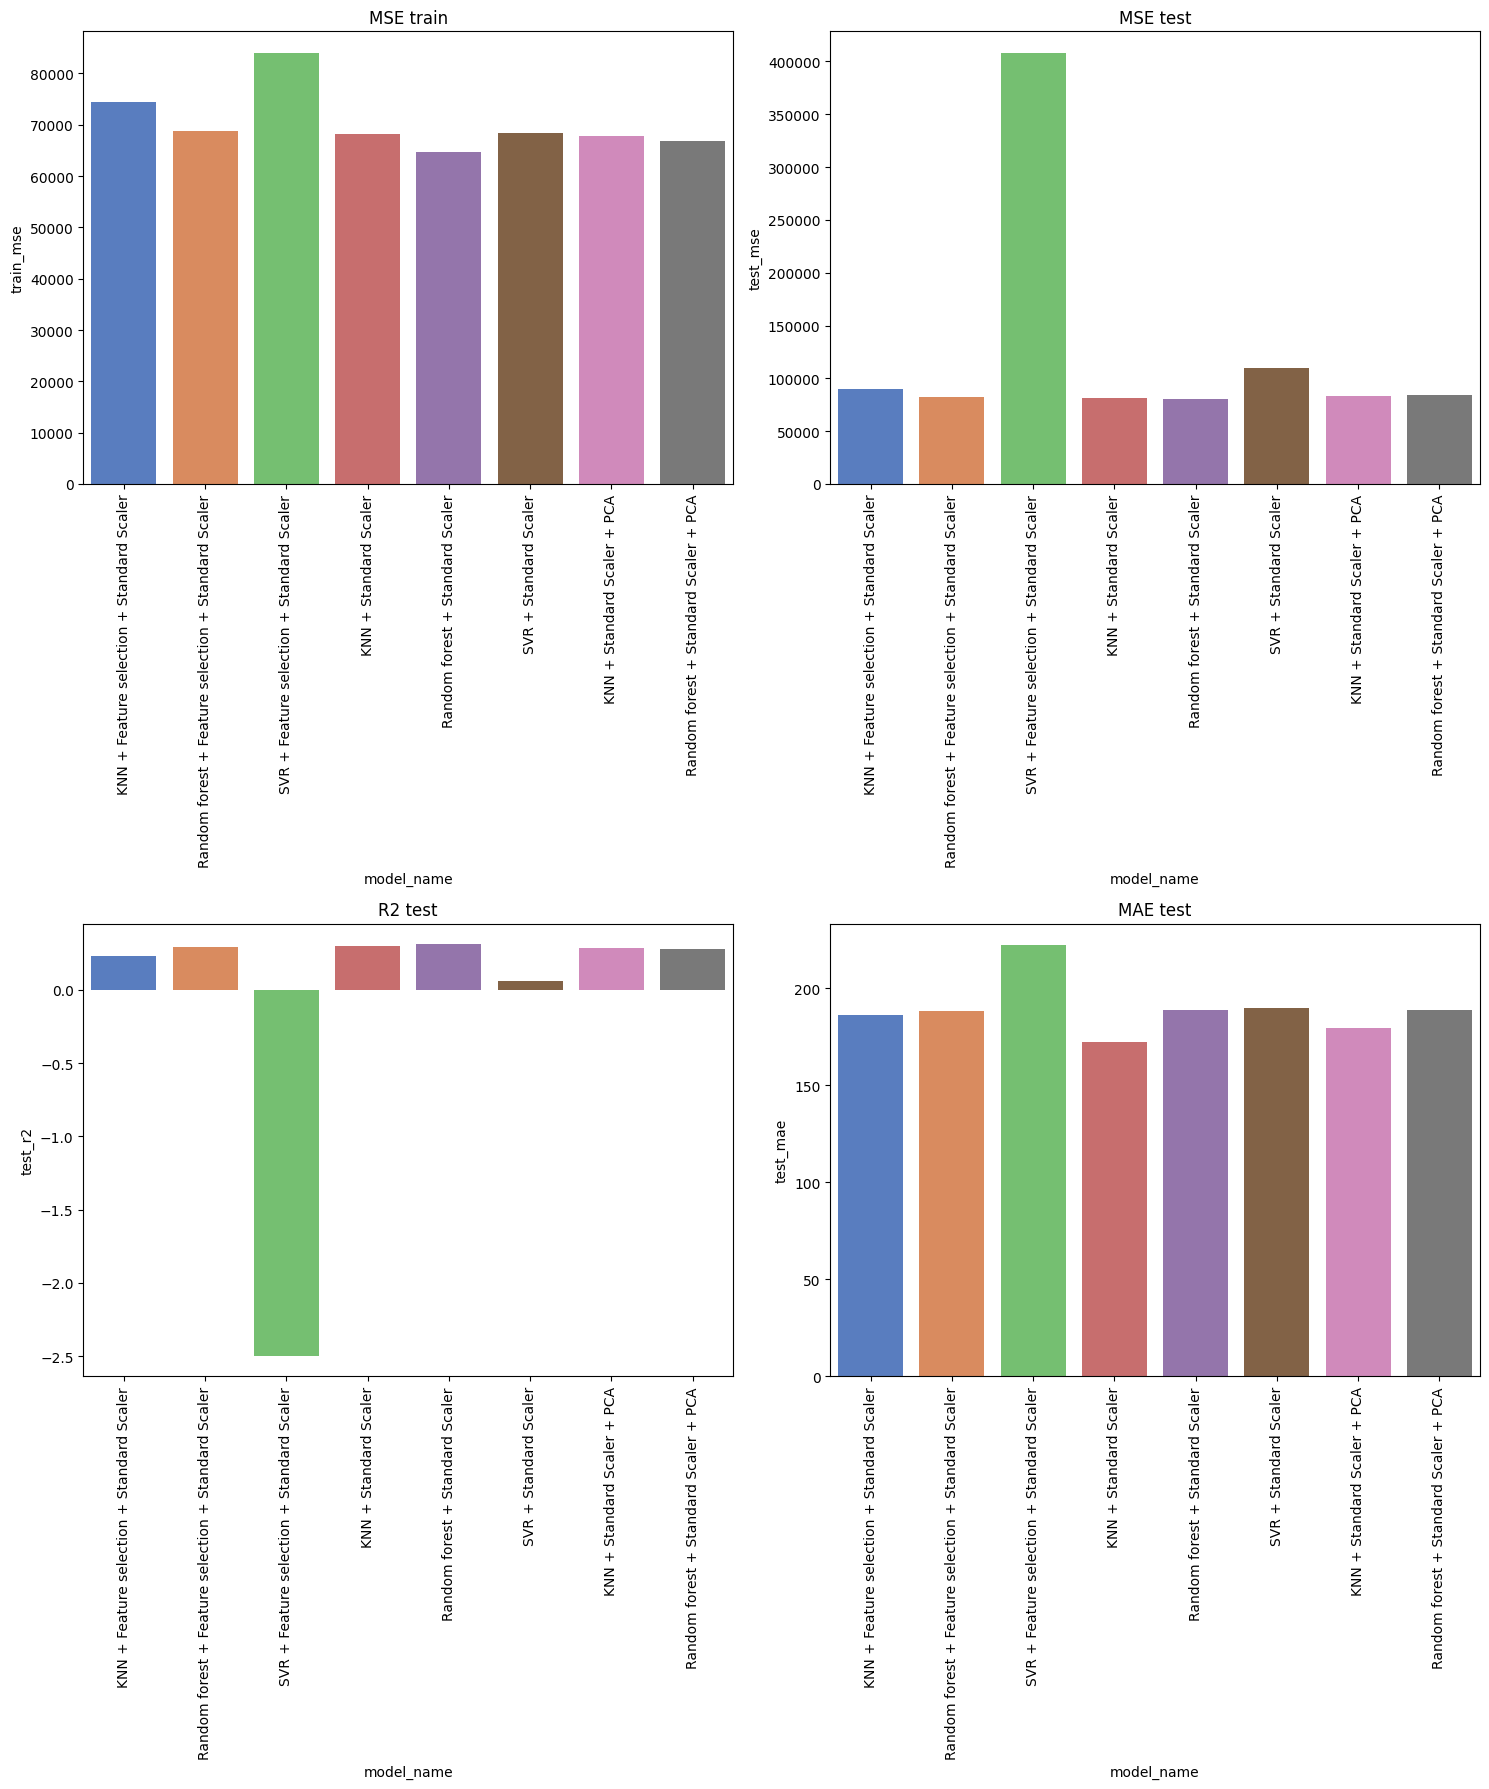

In [ ]:
x_column = 'model_name'
y_column_name_map = {
    'MSE train': 'train_mse',
    'MSE test': 'test_mse',
    'R2 test': 'test_r2',
    'MAE test': 'test_mae'
}

def draw_comparing_score_barplot(x, y_col, title, i_idx, j_idx, df, axes):
  sns.barplot(x=x, y=y_col, data=df, ax=axes[i_idx, j_idx], palette='muted')
  axes[i_idx, j_idx].set_title(title)
  axes[i_idx, j_idx].tick_params(axis='x', rotation=90)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 18))

for idx, (title, y_col) in enumerate(y_column_name_map.items()):
  i_idx = idx // 2
  j_idx = idx % 2
  draw_comparing_score_barplot(x_column, y_col, title, i_idx, j_idx, resulst_df, axes)

plt.tight_layout()
plt.show()